<a href="https://colab.research.google.com/github/UMIAzeez/solar_forecasting/blob/main/Final_Solar_Forecasting_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn numpy
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import datetime
import lightgbm as lgbm
import matplotlib.pyplot as plt
from scipy import stats 

# Read in the data
df = pd.read_csv("/content/drive/MyDrive/FYP my works/Nov_Jan.csv", index_col='Timestamp')
#df = pd.read_csv("/content/drive/MyDrive/FYP my works/PV_Data_Completed.csv", index_col='Timestamp')
df.index = pd.to_datetime(df.index)

df = df.fillna(0)

In [ ]:
df.tail

<bound method NDFrame.tail of                      Total_Power_(kW)  PV_Output  Solar_Irradiance  \
Timestamp                                                            
2022-11-01 00:00:00          208003.0        0.0               0.0   
2022-11-01 00:05:00          208003.0        0.0               0.0   
2022-11-01 00:10:00           39088.0      295.6               0.0   
2022-11-01 00:15:00           42540.0      298.9               0.0   
2022-11-01 00:20:00           37337.0      296.6               0.0   
...                               ...        ...               ...   
2023-02-28 23:35:00           44760.0      422.8               0.0   
2023-02-28 23:40:00           42038.0      421.6               0.0   
2023-02-28 23:45:00           39135.0      423.1               0.0   
2023-02-28 23:50:00           52028.0      425.3               0.0   
2023-02-28 23:55:00           39219.0      426.7               0.0   

                     mTemperature  aTemperature  Rain_Fall 

In [ ]:
# Define a function to create lagged features from the PV_Output, aTemperature, and Solar_Irradiance data
def create_lagged_features(dataframe, lag):
    df_lagged = dataframe.copy()
    df_lagged['PV_Output_lag'] = df_lagged['PV_Output'].shift(lag)
    df_lagged['aTemperature_lag'] = df_lagged['aTemperature'].shift(lag)
    df_lagged['Solar_Irradiance_lag'] = df_lagged['Solar_Irradiance'].shift(lag)
    return df_lagged

    

# Define a function to create rolling mean features from the PV_Output data
def create_rolling_mean_features(dataframe, window):
    df_mean = dataframe.copy()
    df_mean['PV_Output_mean'] = df_mean['PV_Output'].rolling(window=window, min_periods=10, win_type="triang").mean()
    return df_mean

# Define a function to preprocess the data and create the input and output arrays for the model
def create_model_inputs(dataframe, lag, window):
    df_processed = dataframe.copy()
    df_processed = create_lagged_features(df_processed, lag)
    df_processed = create_rolling_mean_features(df_processed, window)
    df_processed = df_processed.dropna()
    X = df_processed[['Solar_Irradiance', 'aTemperature', 'Rain_Fall', 'Wind_speed', 'PV_Output_lag', 'PV_Output_mean']]
    #X = df_processed[['Solar_Irradiance', 'aTemperature', 'Rain_Fall', 'Wind_speed']]#, 'PV_Output_lag', 'PV_Output_mean']]
    #X = df_processed[['PV_Output_lag', 'PV_Output_mean']]
    y = df_processed[['PV_Output']]
    return X, y

# Preprocess the data and split it into train and test sets
lag = 288 # number of time steps to lag
window = 144 # window size for rolling mean
X, y = create_model_inputs(df, lag, window)
X_train, X_test, y_train, y_test = X[:-8064],X[-8064:],y[:-8064],y[-8064:]
# Create the LightGBM model and train it on the data
#model = lgbm.LGBMRegressor(n_estimators=100, learning_rate=0.1)
#model.fit(X_train, y_train)

In [ ]:
model = lgbm.LGBMRegressor(n_estimators=100,
                           nthread=10,
                           max_depth=5,
                           task='train',
                           boosting_type='gbdt',
                           objective='regression_l1',
                           metric='mape',
                           num_leaves=64,
                           learning_rate=0.05,
                           feature_fraction=0.9,
                           bagging_fraction=0.8,
                           bagging_freq=5,
                           lambda_l1=3.097758978478437,
                           lambda_l2=2.9482537987198496,
                           verbose=1,
                           min_child_weight=6.996211413900573,
                           min_split_gain=0.037310344962162616)


model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set and evaluate the model's performance
y_pred = model.predict(X_test[-8064:])
# Get the timestamps of the rows in the test set
timestamps = df.index[-len(X_test[-8064:]):]
# Convert the y_pred list to a DataFrame with the timestamps as the index
y_pred_df = pd.DataFrame(y_pred, index=timestamps, columns=['Predicted_PV_Output'])

y_pred_df = pd.DataFrame(y_pred, columns=['predictions'])
print(f"Test R2 score: {r2_score(y_test[-8064:], y_pred):.2f}")


Test R2 score: 0.90


In [ ]:
# Convert the y_pred list to a DataFrame with the timestamps as the index
timestamps = df.index[-len(X_test[-8064:]):]

y_pred_df = pd.DataFrame(y_pred, index=timestamps, columns=['Predicted_PV_Output'])

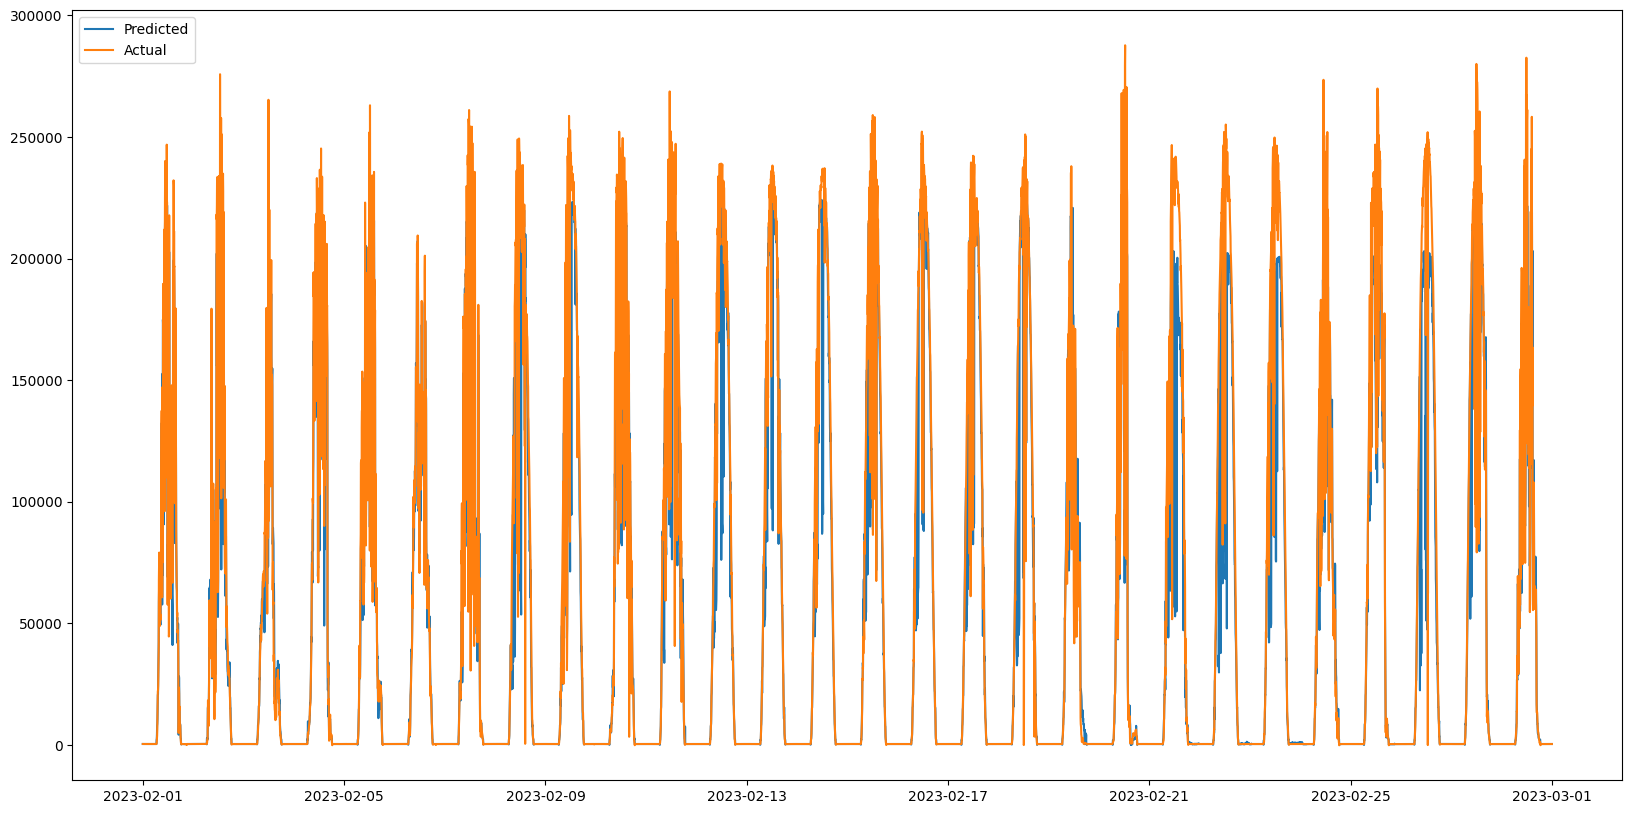

In [ ]:
x_vals = y_test[-8064:].index
y_test_vals = y_test[-8064:]['PV_Output']

plt.figure(figsize=(20, 10))
# Create the plot
#plt.plot(x_vals[-5000:], y_pred[-5000:], label='Predicted')
#plt.plot(x_vals[-5000:], y_test_vals[-5000:], label='Actual')

plt.plot(x_vals[:], y_pred[:], label='Predicted')
plt.plot(x_vals[:], y_test_vals[:], label='Actual')

# Add a legend and show the plot
plt.legend()
plt.show()

In [ ]:
y_test_vals

Timestamp
2023-02-01 00:00:00    444.4
2023-02-01 00:05:00    436.9
2023-02-01 00:10:00    436.7
2023-02-01 00:15:00    434.1
2023-02-01 00:20:00    432.9
                       ...  
2023-02-28 23:35:00    422.8
2023-02-28 23:40:00    421.6
2023-02-28 23:45:00    423.1
2023-02-28 23:50:00    425.3
2023-02-28 23:55:00    426.7
Name: PV_Output, Length: 8064, dtype: float64

In [ ]:
y_train

,PV_Output
Timestamp,
2022-11-02 00:00:00,287.7
2022-11-02 00:05:00,286.2
2022-11-02 00:10:00,288.6
2022-11-02 00:15:00,290.2
2022-11-02 00:20:00,289.7
...,...
2023-01-31 23:35:00,443.0
2023-01-31 23:40:00,443.3
2023-01-31 23:45:00,445.2


In [ ]:
import pandas as pd

# Create a DataFrame with the timestamp and y_pred values
df = pd.DataFrame({'Timestamp': x_vals, 'y_pred': y_pred})

# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/FYP my works/output.csv', index=False)
